# 🔹 Assignment 1: Seq2Seq Model for Sentence Unshuffling
In this assignment, you'll implement a basic **Sequence-to-Sequence (Seq2Seq)** neural network using PyTorch.

### 🎯 **Your goal:**
Given a sentence whose words have been shuffled randomly, your model must reconstruct the original sentence.

**Example:**

| Input (shuffled) | Output (original) |
|-----------------|------------------|
| `mat the on sat cat The` | `The cat sat on the mat` |

## 🔹 Why this task?
This simple yet non-trivial task demonstrates how language models learn word-order and syntactic structures.
From a psycholinguistic viewpoint, sentence reconstruction taps into:

- **Working memory**: The model must hold multiple words and reorder them meaningfully.
- **Syntax and semantics**: Reordering depends on syntactic constraints and semantic coherence.

## 🔹 Quick Summary of PyTorch Workflow

The general workflow when working with on deep learning with PyTorch usually involves these steps:

1. **Prepare your data**:
    - Define your dataset by subclassing `torch.utils.data.Dataset`.
    - Use a `DataLoader` to iterate efficiently over the dataset in batches.
    - Tokenization - select tokenization method and tokenize your data.

2. **Define your model**:
    - Create a model class by subclassing `nn.Module`.
    - Define model layers in `__init__`.
    - Define how data flows through the layers in the `forward()` method.


3. **Training**:
    - Select an appropriate loss function (`nn.CrossEntropyLoss`, `nn.MSELoss`, etc.).
    - Choose an optimizer (`optim.Adam`, `optim.SGD`, etc.).
    - **Training Loop** -- For each batch:
        1. Pass input data through your model to produce predictions (logits).
        2. Compute the loss w.r.t. the gold label (target).
        3. Perform backpropagation (`loss.backward()`) to calculate gradients of all model parameters.
        4. Update the model parameters with your optimizer (`optimizer.step()`).
        5. Reset gradients (`optimizer.zero_grad()`).

This structured workflow helps streamline model development and makes training neural networks clear and efficient.

This notebook will walk you through this process - you need to learn it and the complete the missing code segment marked with a `#TODO` comment.

## 🔹 Step 0: One-time Preparations

### Step 0.1: Install Python Dependencies

In [1]:
%pip install torch pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Step 0.2: Download the Dataset
Download the provided dataset file (`train.csv`) from the following link:

[train.csv](https://drive.google.com/file/d/1eHBj_mdKjPfj_NuXy0zCG5IkQMJLGpPM/view?usp=sharing)

Then upload the file to your Colab notebook or Jupyter environment.

## 🔹 Step 1: Prepare Data

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split

random_seed = 123
random.seed(random_seed)
torch.manual_seed(random_seed)

df = pd.read_csv('train.csv')
df.head()

,Unnamed: 0,input_sentence,target_sentence
0,0,to think need we about. That's something,That's something we need to think about.
1,1,is mountains. the up moon coming over The,The moon is coming up over the mountains.
2,2,committee. the The through Congressmen bill ra...,The Congressmen rammed the bill through commit...
3,3,careful late I'll to never again. be be,I'll be careful never to be late again.
4,4,"please."" gifts, ""No The said, invitation","The invitation said, ""No gifts, please."""


In [3]:
train_df, dev_df = train_test_split(df, test_size=0.1, random_state=42)
print(f"Training examples: {len(train_df)}")
print(f"Development examples: {len(dev_df)}")

Training examples: 31500
Development examples: 3500


#### Pedagogical Note: **Why do we split train data into training and development (dev) sets?**

When developing machine learning models, we want to ensure our model not only performs well on the data it has seen during training but also generalizes effectively to **new, unseen data**.

- **Training set**:  
  Used by the model to learn patterns. This is the data your model sees repeatedly during the training process.

- **Development (dev) set** *(also known as validation set)*:  
  Used to evaluate the model's performance on unseen examples during training. By checking the model periodically against the dev set, we can identify and prevent **overfitting**—when the model performs excellently on training data but poorly on new examples.

Thus, by splitting the data, we ensure our model truly learns generalizable patterns rather than memorizing the specific examples it trained on.


In [4]:
# Handle Vocabulary and Tokenization
from collections import Counter  # for count the number of words easy

def tokenize(sentence):
    return sentence.lower().split() # convert to lowercase letters and then split by spaces

counter = Counter()
for sentence in train_df['input_sentence']:
    counter.update(tokenize(sentence))

# Special Tokens
PAD = '<PAD>' # to fill in when sentence is too short
SOS = '<SOS>' # start of sentence
EOS = '<EOS>' # end of sentence
UNK = '<UNK>'   # to handle out-of-vocabulary words - unknown

words = [PAD, SOS, EOS, UNK] + [w for w, c in counter.items() if c >= 2] # save only words that shows at least twice
# we maintain mapping between words (vocabulary entries) and their ids
word2idx = {w: i for i, w in enumerate(words)} # convert from word to number
idx2word = {i: w for w, i in word2idx.items()} # convert from number to word

vocab_size = len(word2idx)
print(f"Vocabulary size: {vocab_size}")


## this next function get a sentence and convert it to list of numbers in the same length for all
## this is done so that the sentence will be ready to be fed into the model

def encode_sentence(sentence: str, word2idx, max_len):
    # Replace sentence string with a fixed-length list of ints (token_ids with padding)
    tokens = tokenize(sentence) # divide the sentence into words-tokens
    token_ids = [word2idx.get(w, word2idx[UNK]) for w in tokens]
    token_ids = token_ids[:max_len-1] # trim the list so that it is shorter one token  than max_len
    token_ids.append(word2idx[EOS]) # add the EOS token to the end to mark sentence termination
    padding = [word2idx[PAD]] * (max_len - len(token_ids)) # add PAD tokens if needed to make the sentence exactly max_len long
    return token_ids + padding

Vocabulary size: 8531


In [5]:
# Custom Dataset class for sentence-to-sentence mapping
class SentenceDataset(torch.utils.data.Dataset):
    def __init__(self, df, word2idx, max_len):
        # Store input and target sentences as lists of strings
        self.input_sentences = df['input_sentence'].tolist() # input: shuffled sentence
        self.target_sentences = df['target_sentence'].tolist() # target: original sentence
        self.word2idx = word2idx  # mapping from word to index
        self.max_len = max_len    # maximum length of sentence (for padding)

    def __len__(self):
        # Return number of examples in the dataset
        return len(self.input_sentences)

    def __getitem__(self, idx):
        # Encode both input and target sentences to fixed-length tensors of token IDs
        src = encode_sentence(self.input_sentences[idx], self.word2idx, self.max_len)
        trg = encode_sentence(self.target_sentences[idx], self.word2idx, self.max_len)
        return torch.tensor(src), torch.tensor(trg)  # return as PyTorch tensors

# Define batch size and maximum sentence length
# this is the hyperparameters
batch_size = 32
max_len = 50  # All sequences will be padded/truncated to this length

# Create training dataset and dataloader
train_dataset = SentenceDataset(train_df, word2idx, max_len)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# DataLoader loads batches from the dataset and optionally shuffles them

# Create development (validation) dataset and dataloader
dev_dataset = SentenceDataset(dev_df, word2idx, max_len)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size
)


## PyTorch Quick Reference

Since this is your first encounter with PyTorch in the course, here's a short summary of essential PyTorch classes used in this notebook:



---
### ✅ torch.utils.data.Dataset
#### What is it?

An abstract class representing your dataset. It lets you define exactly how to access and prepare each data point.

#### How to use it?

You subclass it and implement two methods:

`__len__(self)`: returns the size of your dataset.

`__getitem__(self, index)`: returns one data point (input-target pair).

#### Why do we use it?
It provides a clean way to structure your data and feed it systematically into your model.

---
### ✅ torch.utils.data.DataLoader
#### What is it?
A utility that takes a Dataset object and provides an iterator over it.

#### How to use it?
Specify batch size, shuffle options, and more:

```python
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```
#### Why do we use it?
It handles batching, shuffling, and efficient parallel data loading automatically—making your training loop concise and efficient.

---
### ✅ torch.nn.Module
#### What is it?
The base class for all neural network models in PyTorch. Every model you build inherits from it.

#### How to use it?
You subclass it, define your layers in the constructor (`__init__`), and specify the forward pass in the `forward()` method:

```python
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.linear = nn.Linear(10, 1)
    
    def forward(self, x):
        return self.linear(x)
```
#### Why do we use it?
It manages model parameters, handles the forward computation, and simplifies tasks such as moving models to GPU or tracking gradients automatically.




## 🔹 Step 2: Define Model

### Building blocks - Enocder and Decoder

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # TODO: define layers used in the encoder, e.g. embedding and LSTM layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size) # convert every word into vector in size 64
        self.lstm = nn.LSTM(embedding_size, hidden_size, dropout = 0.3) # send this vectors to LSTM, and we add dropout to prevent overfit

        # the function forward is how the data pass through the model
    def forward(self, input, hidden):
        """
        input: (seq_len, batch_size) - token indices for input sentence
        hidden: (1, batch_size, hidden_size) - initial hidden state
        Returns:
            output: all hidden states for the input sequence
            hidden: final hidden state
        """
        # TODO: implement the forward pass here
        embedded = self.embedding(input)  # (seq_len, batch, embedding_size)
        output, hidden = self.lstm(embedded, hidden)  # pass the vectors into the LSTM
        return output, hidden

    #def init_hidden(self, batch_size):
    #    return torch.zeros(1, batch_size, hidden_size)
    
    def init_hidden(self, batch_size):
        return (
            torch.zeros(1, batch_size, self.hidden_size),  # h_0
            torch.zeros(1, batch_size, self.hidden_size)   # c_0
        )

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(DecoderRNN, self).__init__()
        # TODO: define layers used in the decoder, e.g. embedding, LSTM and linear layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)  # words to vectors
        self.lstm = nn.LSTM(embedding_size, hidden_size)  # vectors from before to LSTM
        self.out = nn.Linear(hidden_size, vocab_size)  # layer for predict the next word

    def forward(self, input, hidden):
        """
        input: (batch_size) - current token index at this decoding step
        hidden: (1, batch_size, hidden_size) - current hidden state
        Returns:
            output: prediction for the next word (before softmax)
            hidden: updated hidden state
        """
        # TODO: Embed the input token, run one step of the RNN, generate output
        embedded = self.embedding(input).unsqueeze(0)  # # add time dimension
        output, hidden = self.lstm(embedded, hidden)  # run one step of LSTM
        output = self.out(output.squeeze(0))  # predict next word
        return output, hidden


In [7]:
# Define Encoder & Decoder
embedding_size = 64
hidden_size = 128

encoder = EncoderRNN(vocab_size, embedding_size, hidden_size)
decoder = DecoderRNN(vocab_size, embedding_size, hidden_size)

# Sanity Checks
sample_input, sample_target = next(iter(train_loader))
encoder_hidden = encoder.init_hidden(sample_input.size(0))
encoder_output, encoder_hidden = encoder(sample_input.T, encoder_hidden)

decoder_input = torch.tensor([word2idx[SOS]] * sample_input.size(0))
decoder_hidden = encoder_hidden

decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

print("Encoder output shape:", encoder_output.shape)
print("Decoder output shape:", decoder_output.shape)


C:\Users\avich\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Encoder output shape: torch.Size([50, 32, 128])
Decoder output shape: torch.Size([32, 8531])


### Seq2Seq model that wraps Encoder and Decoder together

In [9]:
class Seq2Seq(nn.Module): # encoder decoder in one piece
    def __init__(self, encoder, decoder, sos_idx, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.device = device  # needed for creating new tensors like hidden states

    def forward(self, src, trg):
        """
        src: (batch_size, seq_len) - input sentence (shuffled)
        trg: (batch_size, seq_len) - target sentence (original)
        Returns:
            outputs: tensor of shape (batch_size, seq_len, vocab_size)
        """
        batch_size, trg_len = trg.shape
        vocab_size = self.decoder.out.out_features

        # Create an empty tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, vocab_size, device=self.device)

        # Transpose inputs to match (seq_len, batch_size)
        src = src.T
        trg = trg.T

        # Initialize hidden state on correct device
        hidden = self.encoder.init_hidden(batch_size)

        # Encode the input sentence
        _, hidden = self.encoder(src, hidden)

        # Start decoding with the <SOS> token
        input = torch.full((batch_size,), self.sos_idx, device=self.device)

        for t in range(trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t, :] = output
            input = trg[t]  # teacher forcing: feed the true token at each step

        return outputs


## 🔹 Step 3: Training

In [15]:
# define the training-loop function
def train_model(model, train_loader, dev_loader, optimizer, criterion, device, num_epochs=5):
    model.to(device)
    train_losses = []
    dev_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)

            optimizer.zero_grad()
            output = model(src, trg)

            # output: (batch, seq_len, vocab_size)
            # trg: (batch, seq_len)
            output = output.view(-1, output.shape[-1])  # shape: (batch * seq_len, vocab_size)
            trg = trg.view(-1)                          # shape: (batch * seq_len)

            # Compute the loss
            loss = criterion(output, trg)

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Evaluate on dev set
        model.eval()
        dev_loss = 0

        with torch.no_grad():
            for src, trg in dev_loader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg)
                output = output.view(-1, output.shape[-1])
                trg = trg.view(-1)
                loss = criterion(output, trg)
                dev_loss += loss.item()

        dev_losses.append(dev_loss / len(dev_loader))

        # --- Clean and formatted output ---
        bar = "=" * 60
        print(f"\n{bar}")
        print(f"{'EPOCH':<12}: {epoch + 1} / {num_epochs}")
        print(f"{'Train Loss':<12}: {train_losses[-1]:.4f}")
        print(f"{'Dev Loss':<12}: {dev_losses[-1]:.4f}")
        print(f"{bar}\n")

    return train_losses, dev_losses



In [16]:
# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2Seq(encoder, decoder, word2idx[SOS], device)

# Choose optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD])

# Run training
train_losses, dev_losses = train_model(
    model, train_loader, dev_loader,
    optimizer, criterion, device,
    num_epochs=5
)


EPOCH       : 1 / 5
Train Loss  : 4.8715
Dev Loss    : 4.4924


EPOCH       : 2 / 5
Train Loss  : 4.3881
Dev Loss    : 4.1233


EPOCH       : 3 / 5
Train Loss  : 3.9795
Dev Loss    : 3.8006


EPOCH       : 4 / 5
Train Loss  : 3.6659
Dev Loss    : 3.6057


EPOCH       : 5 / 5
Train Loss  : 3.4344
Dev Loss    : 3.4583



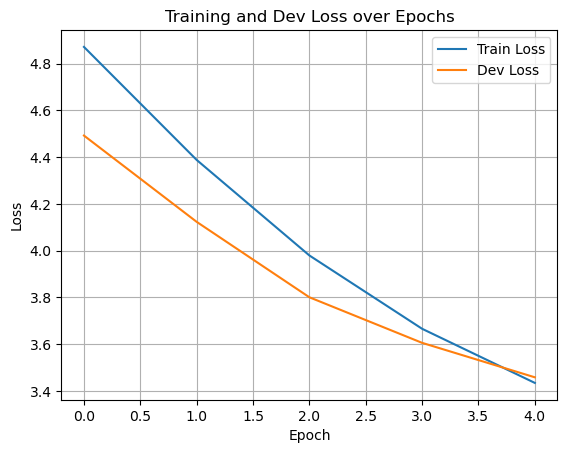

In [17]:
# Helper - loss visualizations
import matplotlib.pyplot as plt

def plot_losses(train_losses, dev_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(dev_losses, label='Dev Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Dev Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, dev_losses)

### Pedagogical Note: Interpreting the Loss Plots 🔍

After training completes, you'll see two curves:

- **Train Loss**: How well the model fits the training data.
- **Dev Loss**: How well the model generalizes to unseen (validation) data.

Ideally:
- Both curves should **decrease over time**.
- A small gap between them indicates **good generalization**.
- If train loss decreases but dev loss increases, your model may be **overfitting**.

Use these curves to decide if your model is learning stably and when to stop training.


## Step 4: Inference
Now that you have a trained model, you can use it to solve your task on any new data points.

Complete the code below for implementing a inference function for the model.

In [ ]:
def infer_sentences(shuffled_sentences, model, word2idx, idx2word, device, max_len=50):
    """
    Generate predicted (unshuffled) sentences from a list of shuffled input sentences.

    Args:
        shuffled_sentences (List[str]): Sentences with words in randomized order.
        model (Seq2Seq): Trained encoder-decoder model.
        word2idx (Dict[str, int]): Mapping from words to vocabulary indices.
        idx2word (Dict[int, str]): Mapping from indices to words.
        device (torch.device): CPU or CUDA device for inference.
        max_len (int): Maximum sentence length to decode.

    Returns:
        List[str]: Model's predicted sentences (as plain strings).
    """
    model.eval()
    predictions = []

    sos_idx = word2idx['<SOS>']
    eos_idx = word2idx['<EOS>']
    pad_idx = word2idx['<PAD>']

    with torch.no_grad():
        for sentence in shuffled_sentences:
            # TODO
            predicted_sentence: str = ...
            predictions.append(predicted_sentence)

    return predictions



Now, use the above inference function to generate prediction for the **test set**. You are provided with the test set shuffled sentences in [this downloadable file](https://drive.google.com/file/d/178mEesTW89Ooz_f5bb6sHBHjAkG4DWMV/view?usp=sharing). In your submission, you should run the inference function of the provided list of shuffled sentences, to attain a `predicted_test.csv` file. Typically, these predictions over the test set will be evaluated against their annotated labels (targets).  

If you want to assess the quality of current trained model, you can run inference on the dev set and evaluate on it using the function below:

In [ ]:
def evaluate_sentence_predictions(predictions, targets):
    """
    Compute exact match accuracy between predicted and target sentences (as strings).
    Args:
        predictions (List[str])
        targets (List[str])
    Returns:
        accuracy (float): percentage of exact string matches
    """
    correct = 0
    total = len(predictions)
    for pred, true in zip(predictions, targets):
        if pred.strip() == true.strip():
            correct += 1
    accuracy = correct / total * 100
    print(f"Exact match accuracy: {accuracy:.2f}%")
    return accuracy

# 🔁 Stage 2: Add Attention to Your Seq2Seq Model

In this stage, you'll implement a new model: **`Seq2SeqWithAttention`**.  
The goal is to improve your decoder by allowing it to "attend" to relevant parts of the encoder's outputs at each decoding step.

### 🧠 Why Attention?
The encoder compresses the entire input sentence into a single hidden state. This limits performance, especially on long sentences.

With attention, the decoder **dynamically focuses on different encoder outputs**, depending on what it's trying to generate.

---

### 🔧 What You Need to Implement:
You will create a new class `Seq2SeqWithAttention`, similar to `Seq2Seq`, but with the following differences:

1. At each decoding step, compute **attention scores** over all encoder hidden states.
2. Use those scores to compute a **context vector** (weighted sum of encoder outputs).
3. Feed the context vector into the decoder along with the embedding of the current input token.

---

### 📌 Tip: Dot-Product Attention
A simple form of attention you can implement is dot-product attention:

```python
score_t = dot(h_dec_t, h_enc_i) weights = softmax(score_t over i) context_t = sum_i weights[i] * h_enc_i
```

You'll apply this at every decoder time step.


In [ ]:
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, device):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.device = device

        # TODO: If needed, add additional layers for attention (e.g., linear projection)

    def compute_attention(self, decoder_hidden, encoder_outputs):
        """
        decoder_hidden: (1, batch_size, hidden_size)
        encoder_outputs: (seq_len, batch_size, hidden_size)

        Returns:
            context vector: (batch_size, hidden_size)
        """
        # TODO: implement dot-product attention or another variant
        # Steps:
        # 1. Compute attention scores: dot(decoder_hidden, encoder_outputs)
        # 2. Apply softmax to get attention weights
        # 3. Compute context vector: weighted sum of encoder_outputs
        return context_vector

    def forward(self, src, trg):
        """
        src: (batch_size, seq_len)
        trg: (batch_size, seq_len)
        Returns:
            outputs: (batch_size, seq_len, vocab_size)
        """
        batch_size, trg_len = trg.shape
        vocab_size = self.decoder.out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size, device=self.device)

        src = src.T
        trg = trg.T

        hidden = self.encoder.init_hidden(batch_size)
        encoder_outputs, hidden = self.encoder(src, hidden)  # encoder_outputs: (seq_len, batch_size, hidden_size)

        input_token = torch.full((batch_size,), self.sos_idx, device=self.device)

        for t in range(trg_len):
            # TODO: Compute context vector based on current hidden and encoder_outputs
            context = self.compute_attention(hidden, encoder_outputs)

            # TODO: Modify decoder forward to accept and use the context vector
            # Hint: You may need to add context to the input embedding, or to the hidden state
            output, hidden = self.decoder(input_token, hidden, context)

            outputs[:, t, :] = output
            input_token = trg[t]  # teacher forcing

        return outputs


## 📝 What You Need to Complete

- Implement the `compute_attention()` method to compute a context vector from encoder outputs given the current (decoder) hidden state.
- Update your `DecoderRNN` class so that it accepts and uses a context vector at every step:
    - One option is to **concatenate** the context vector with the embedded input token before passing it to the RNN.
    - Alternatively, you can feed the context into a projection layer together with the decoder hidden state.

---

### 📌 Tip: Updated Decoder Signature

You may need to rewrite your decoder to look like:

```python
def forward(self, input_token, hidden, context_vector):
    ...
```
---
> 💡 **Note on Attention Implementation**

You are given flexibility in how you choose to implement the attention mechanism.

You may:
- Implement the **basic dot-product attention** we discussed in class.
- Or, explore a more expressive variant by adding a **linear projection** to the decoder hidden state or the encoder outputs — borrowing an idea from self-attention in Transformers.

As long as your implementation uses the decoder hidden state to compute attention over the encoder outputs and forms a context vector, you're free to experiment and design the solution that makes most sense to you.


## 2.2 - Evaluate and Compare

In this stage, you should use your adapted `Seq2SeqWithAttention` model, train it and evaluate its performance (on the dev set).  

In [ ]:
# Instantiate and Train a Seq2SeqWithAttention model
# TODO

## 📌 Submission Instructions:
Submit your completed notebook along with two files of predictions over the test set - `seq2seq_predictions.csv` and `seq2seq_with_attention_predictions.csv`.

I will run the evaluation over the held-out test set.

You should email all of these files with an email specifying the names and ids of the team (couples).

✅ **Good luck!**
